In [4]:
import src.autoencoder.models.classicalAE as cae
import src.autoencoder.models.VAEs as vae
import torch
import torch.nn as nn
import nibabel as nib
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt
from monai.losses.ssim_loss import SSIMLoss


In [5]:
model = "UVAE_sel2"
type_ae = model.split("_")[0].lower()

if type_ae == "vae3d":
    net = vae.VAE3D([182, 218, 160], 1, latent_dim=2048)
elif type_ae == "uvae":
    net = vae.U_VAE(in_channels=1,  init_features=4,
                    num_blocks=6, input_dim=[182, 218, 160],
                    attention=None, hidden_size=2048)
else:
    net = cae.BaseAE(in_channels=1,
                     init_features=4, num_blocks=6, type_ae=type_ae,
                     dropout=0.1, attention=None)


net = nn.DataParallel(net)
bckp = torch.load(f"/home/tbarba/projects/MultiModalBrainSurvival/outputs/norm/{model}/exports/best_model.pt")
net.load_state_dict(bckp)

<All keys matched successfully>

In [6]:
def compute_ssim(orig_nifti, output):
    ssim_func = SSIMLoss(spatial_dims=3)

    imgs = nib.load(orig_nifti)
    rescale = tio.RescaleIntensity(out_min_max=(0, 1))
    imgs = rescale(imgs).get_fdata()
    imgs = np.array(imgs, dtype=np.float16)
    imgs = np.expand_dims(imgs, axis=0)  # adding channel dim
    imgs = imgs.transpose((0, 3, 2, 1))  # reorder channels
    imgs = np.expand_dims(imgs, axis=0)  # adding batch dim
    orig = torch.Tensor(imgs)

    ssim_loss = ssim_func(orig, output, data_range=orig.max()).item()
    ssim = 1 - ssim_loss
    
    return ssim


net.eval()

image = "/home/tbarba/projects/MultiModalBrainSurvival/data/MR/TCGA/processed/TCGA-HT-8114/normT2_crop.nii.gz"
orig = nib.load(image).get_fdata()
output, embedding = net.module.process_nifti(image)
reconstructed = output.squeeze().detach().numpy().transpose((2,1,0))
images = {"orig":orig, "recontr":reconstructed}

ssim = compute_ssim(image, output)



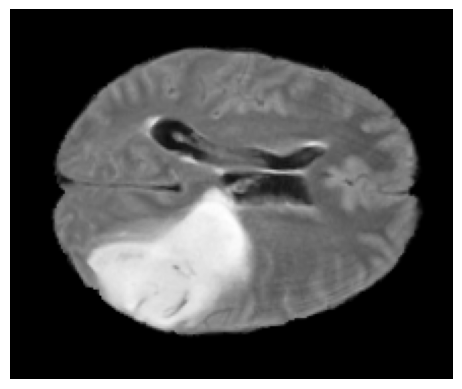

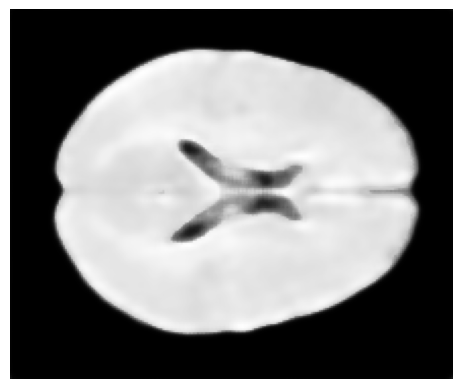

SSIM = 80.53%


In [7]:
slice = 90
for k, im in images.items():
    plt.imshow(im[:,:,slice], cmap="Greys_r")
    plt.axis('off')
    plt.savefig(f"Z-{k}.png",
                bbox_inches='tight',
                pad_inches=0,
                format='png',
                dpi=300)
    plt.show()

print(f"SSIM = {100*ssim:.2f}%")

In [84]:
from monai.losses.ssim_loss import SSIMLoss
ssim_func = SSIMLoss(spatial_dims=3)
orig_tens = torch.tensor(orig.transpose(2,1,0)).unsqueeze(dim=0).unsqueeze(0)
ssim_result = ssim_func(orig_tens, output.double(), data_range=orig_tens.max()).item()